## Create the two loops

In [1]:
import sys
import sys
import os
ROOT  = "../"
# Add current working directory to sys.path
sys.path.append(ROOT)
sys.path.append("/home/mehdii/projects/def-vidalthi/mehdii/3DPU_Plateau_Problem/")
from PointList import *
%matplotlib widget 
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from _3DLoops._3dpu_using_dfs import *
from Block_edges.block_edges import *

## The two loops

In [2]:
def loop(r,O, num_points):
    xo,yo,zo = O
    points = PointList()
    for n in tqdm(range(num_points)):
        theta = n * 2 * math.pi / num_points
        x = r * math.cos(theta) + xo
        y = r * math.sin(theta) + yo
        points.add_point((x,y,zo))
    return points

In [3]:
points1 = loop(10,(0,0,0.5), 100)
points2 = loop(10,(0,0,4.5), 100)

100%|██████████| 100/100 [00:00<00:00, 533626.46it/s]


## Fill in the said loop

In [4]:
loops = [points1,points2]
List_M = []
for loop in loops:
    M = Edge_Flipping(loop,10*len(loop.points))
    M.create_quadrilaterals()
    M.split_quadrilateral()
    M.canonic_representation_from_mesh()
    M.clean_triangles()
    M.fill_edges()
    M.update_weights()
    M.mapping = [np.array(o) for o in M.mapping]
    List_M.append(M)

s is 4


100%|██████████| 501/501 [00:00<00:00, 553568.57it/s]


100%|██████████| 401/401 [00:00<00:00, 30673.42it/s]


s is 4


100%|██████████| 401/401 [00:00<00:00, 30613.69it/s]


In [5]:
epsilon = 0.01
List_edges = []
for M in List_M:
    area = M.calculate_area()
    print(len(M.triangles))
    for i in tqdm(M.inside_indexes):
        M.update_mapping(i)
    D = M.lawson_flip()
    new_area = M.calculate_area()
    print(new_area,area - new_area,M.compute_mean_curvature(),M.vertex_curvatures[M.compute_mean_curvature()])
    while  area - new_area > epsilon:
        area = M.calculate_area()
        M.update_weights()
        for i in tqdm(M.inside_indexes):
            M.update_mapping(i)
        M.lawson_flip()
        new_area = M.calculate_area()
    E = Block_edges(M.triangles,M.mapping)
    E.block_all_the_edges()
    List_edges.append(E.blocked_edges)


900


100%|██████████| 401/401 [00:00<00:00, 47272.71it/s]
1512it [00:00, 45754.39it/s]            
1406it [00:00, 51423.46it/s]            
100%|██████████| 1400/1400 [00:00<00:00, 52423.18it/s]


313.9525976465675 -2.7853275241795927e-12 4.270054181896677e-08 164


100%|██████████| 900/900 [00:03<00:00, 246.02it/s]


900


100%|██████████| 401/401 [00:00<00:00, 43233.58it/s]
1517it [00:00, 45293.63it/s]            
1408it [00:00, 51054.09it/s]            
100%|██████████| 1400/1400 [00:00<00:00, 51978.63it/s]


313.95259764656697 -2.2737367544323206e-12 1.5301510477254086e-10 157


100%|██████████| 900/900 [00:03<00:00, 249.41it/s]


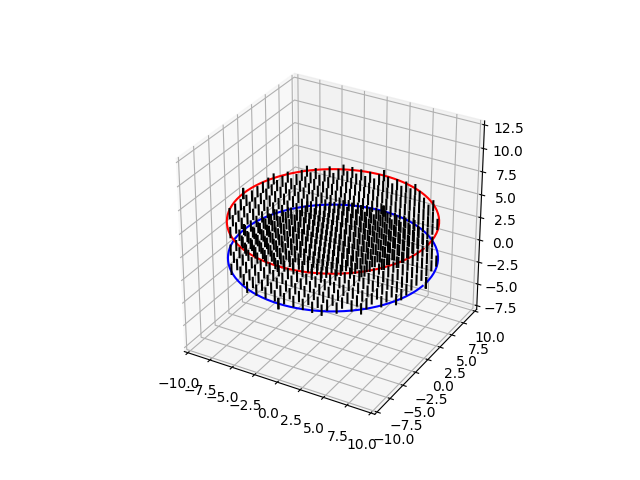

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')

X = []
Y = []
Z = []

# Draw loop of points
for point in points1.points:
    x, y, z = point
    X.append(x)
    Y.append(y)
    Z.append(z)

ax.plot(X, Y, Z, color='b')

X1,Y1,Z1 = [],[],[]

for point in points2.points:
    x, y, z = point
    X1.append(x)
    Y1.append(y)
    Z1.append(z)



ax.plot(X1, Y1, Z1, color='red')

for Edges in List_edges:
    for edge in Edges:
        ax.plot([edge[0][0],edge[1][0]],[edge[0][1],edge[1][1]],[edge[0][2],edge[1][2]],color='black')
        
X = np.concatenate((X,X1))
Y = np.concatenate((Y,Y1))
Z = np.concatenate((Z,Z1))

max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0 

mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

plt.show()


## Gurobi Model

In [ ]:
Edges = []
for list_edges in tqdm(List_edges):
    for edge in list_edges:
        Edges.append([list(edge[0]),list(edge[1])])

100%|██████████| 2/2 [00:00<00:00, 569.07it/s]


In [7]:
class GraphGrid3D:

    def __init__(self,x_min,x_max,y_min,y_max,z_min,z_max):
        # Constructor code here
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.z_min = z_min
        self.z_max = z_max
        self.mapping = []
        self.index_mapping = {}
        self.edges = {}
        self.marked = {}
        self.Graph = {}

    def fill_mapping(self):
        cpt = 0
        for i in range(self.x_min,self.x_max):
            for j in range(self.y_min,self.y_max):
                for k in range(self.z_min,self.z_max):
                    self.mapping.append((i,j,k))
                    self.index_mapping[(i,j,k)] = cpt
                    cpt += 1

    def get_neighbors(self,point):
        i,j,k = point
        neighbors = []
        if i < self.x_max - 1:
            neighbors.append(self.index_mapping[(i+1,j,k)])
        if i > self.x_min:
            neighbors.append(self.index_mapping[(i-1,j,k)])
        if j < self.y_max - 1:
            neighbors.append(self.index_mapping[(i,j+1,k)])
        if j > self.y_min:
            neighbors.append(self.index_mapping[(i,j-1,k)])
        if k < self.z_max - 1:
            neighbors.append(self.index_mapping[(i,j,k+1)])
        if k > self.z_min:
            neighbors.append(self.index_mapping[(i,j,k-1)])
        return neighbors

    def create_graph(self):
        for point in self.mapping:
            self.Graph[self.index_mapping[point]] = []
        for point in self.mapping:
            self.Graph[self.index_mapping[point]] = self.get_neighbors(point)
    



In [8]:
import sys
sys.path.append("/home/mehdii/projects/def-vidalthi/mehdii/3DPU_Plateau_Problem/")
from CreatingGraph import *

ModuleNotFoundError: No module named 'CreatingGraph'

In [ ]:
G = GraphGrid3D(0,10,0,10,0,10)
G.fill_mapping()
G.create_graph()

## Making list from python to c++

In [ ]:
with open('list.txt', 'w') as file:
    for item in Edges:
        file.write(f"{item}\n")

In [ ]:
Edges

[[[2, 8, 0], [2, 8, 1]],
 [[-1, -9, 0], [-1, -9, 1]],
 [[-9, -2, 0], [-9, -2, 1]],
 [[-8, -2, 0], [-8, -2, 1]],
 [[2, -6, 0], [2, -6, 1]],
 [[-5, 1, 0], [-5, 1, 1]],
 [[2, -7, 0], [2, -7, 1]],
 [[1, -3, 0], [1, -3, 1]],
 [[1, 0, 0], [1, 0, 1]],
 [[2, 0, 0], [2, 0, 1]],
 [[9, 4, 0], [9, 4, 1]],
 [[-6, 3, 0], [-6, 3, 1]],
 [[4, 6, 0], [4, 6, 1]],
 [[1, -4, 0], [1, -4, 1]],
 [[6, 6, 0], [6, 6, 1]],
 [[-1, -7, 0], [-1, -7, 1]],
 [[1, -5, 0], [1, -5, 1]],
 [[-7, 6, 0], [-7, 6, 1]],
 [[1, 6, 0], [1, 6, 1]],
 [[3, 7, 0], [3, 7, 1]],
 [[4, 0, 0], [4, 0, 1]],
 [[6, -6, 0], [6, -6, 1]],
 [[4, 4, 0], [4, 4, 1]],
 [[3, -4, 0], [3, -4, 1]],
 [[4, 7, 0], [4, 7, 1]],
 [[5, 8, 0], [5, 8, 1]],
 [[-3, 0, 0], [-3, 0, 1]],
 [[-7, -7, 0], [-7, -7, 1]],
 [[-7, 0, 0], [-7, 0, 1]],
 [[0, 5, 0], [0, 5, 1]],
 [[0, -8, 0], [0, -8, 1]],
 [[2, -1, 0], [2, -1, 1]],
 [[-6, -5, 0], [-6, -5, 1]],
 [[1, 9, 0], [1, 9, 1]],
 [[3, -8, 0], [3, -8, 1]],
 [[-2, -6, 0], [-2, -6, 1]],
 [[-3, -7, 0], [-3, -7, 1]],
 [[-6, 0, 0],

In [ ]:
!pip install pulp

Defaulting to user installation because normal site-packages is not writeable
Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2020/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/avx2, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2020/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
  Obtaining dependency information for pulp from https://files.pythonhosted.org/packages/09/d7/57e71e11108203039c895643368c0d1a99fe719a6a80184edf240c33d25f/PuLP-2.8.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 218.4 kB/s eta 0:00:0000:0100:03


In [ ]:
import pulp as pl

# Create a new MIP model
model = pl.LpProblem("MIP Model", pl.LpMinimize)

# Define your decision variables
x = pl.LpVariable("x", lowBound=0, cat="Integer")
y = pl.LpVariable("y", lowBound=0, cat="Integer")

# Define your objective function
model += 3*x + 4*y

# Define your constraints
model += 2*x + y >= 5
model += x + 3*y >= 4

# Solve the MIP model
model.solve()

# Print the optimal solution
print("Optimal Solution:")
print("x =", pl.value(x))
print("y =", pl.value(y))


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/mehdii/.local/lib/python3.11/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/f96a9d7b87e046bd88514dd8546b239c-pulp.mps -timeMode elapsed -branch -printingOptions all -solution /tmp/f96a9d7b87e046bd88514dd8546b239c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7 COLUMNS
At line 18 RHS
At line 21 BOUNDS
At line 24 ENDATA
Problem MODEL has 2 rows, 2 columns and 4 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 9 - 0.00 seconds
Cgl0003I 0 fixed, 2 tightened bounds, 0 strengthened rows, 0 substitutions
Cgl0004I processed model has 2 rows, 2 columns (2 integer (0 of which binary)) and 4 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0012I Integer solution of 12 found by greedy cover after 0 iterations and 0 nodes (0.00 seconds)
Cbc0012I Integer solution of 10 found by Dive